# LangGraph 201: Building a Deep Research Agent

In this notebook, we'll build a multi-agent research system that can conduct comprehensive web research. We'll progressively build up the system in three parts:

1. **Part 1**: Single researcher agent that performs web searches
2. **Part 2**: Supervisor agent that coordinates multiple researchers
3. **Part 3**: Complete workflow with user clarification and report generation

This follows a common multi-agent pattern where a supervisor delegates work to specialized sub-agents.

## Pre-work: Setup

First, let's install dependencies and set up our environment.

#### Loading environment variables

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# OpenAI API key required for researcher
if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY not found in environment variables")


#### Import required libraries

In [2]:
import json
import asyncio
import operator
from datetime import datetime
from typing import Literal, Annotated

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
    filter_messages,
    get_buffer_string,
    MessageLikeRepresentation
)
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt
from typing_extensions import TypedDict

#### Helper functions

In [3]:
def get_today_str() -> str:
    """Get current date formatted for display."""
    now = datetime.now()
    return f"{now:%a} {now:%b} {now.day}, {now:%Y}"

def openai_websearch_called(response):
    """Detect if OpenAI's web search was used."""
    try:
        tool_outputs = response.additional_kwargs.get("tool_outputs")
        if not tool_outputs:
            return False
        for tool_output in tool_outputs:
            if tool_output.get("type") == "web_search_call":
                return True
        return False
    except (AttributeError, TypeError):
        return False

#### Configuration

Let's define our hardcoded configuration. In a production system, these would be configurable, but for this educational example we'll keep them simple and visible.

In [4]:
# Model configuration
RESEARCH_MODEL = "openai:gpt-4.1" # Hard requirement for this notebook
MAX_OUTPUT_TOKENS = 10000

# Research limits
MAX_RESEARCHER_ITERATIONS = 3  # How many times supervisor can delegate
MAX_REACT_TOOL_CALLS = 10      # Max tool calls per researcher
MAX_CONCURRENT_RESEARCH_UNITS = 5  # Max parallel researchers
MAX_STRUCTURED_OUTPUT_RETRIES = 3

# Initialize model
def get_model():
    return init_chat_model(
        model=RESEARCH_MODEL,
        max_tokens=MAX_OUTPUT_TOKENS,
        api_key=os.getenv("OPENAI_API_KEY"),
        use_responses_api=True
    )

print(f"✓ Configuration set: {RESEARCH_MODEL}")

✓ Configuration set: openai:gpt-4.1


## Part 1: Building a Single Researcher Agent

We'll start by building a single researcher agent that can:
1. Receive a research topic
2. Use web search to gather information
3. Compress the findings into a summary

This agent uses a ReAct (Reasoning and Acting) pattern with web search capabilities.

### 1.1 Define State

How does information flow through the steps?  

State is the first LangGraph concept we'll cover. **State can be thought of as the memory of the agent - its a shared data structure that’s passed on between the nodes of your graph**, representing the current snapshot of your application. 

For our Researcher, we'll define 3 fields to track: the conversation history, the topic, and how many API calls it has made. 

We can also define specific output State to indicate what we expect the researcher to return.

In [5]:
class ResearcherState(TypedDict):
    """State for a single researcher agent."""
    researcher_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    research_topic: str        # What to research
    tool_call_iterations: int  # How many tool calls made

class ResearcherOutputState(TypedDict):
    """Output from researcher - just the compressed findings."""
    researcher_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    compressed_research: str   # Summary of findings
    raw_notes: list           # Raw notes for later use

### 1.2 Define Tools

Let's define a list of **tools** our agent will have access to. Tools are functionts that can act as extension of the LLM's capabilities. 

We'll define some no-op tools that will allow our researcher to reflect and indicate when research is complete.

Finally, to actually conduct research, our agent needs access to web search. We'll use OpenAI's native web search capability.

In [6]:
@tool(description="Signal that research is complete")
def ResearchComplete() -> str:
    """Call this when you have gathered enough information to answer the research question."""
    return "Research marked as complete"

@tool(description="Strategic reflection tool for research planning")
def think_tool(reflection: str) -> str:
    """Use this tool after each search to analyze results and plan next steps.
    
    Args:
        reflection: Detailed reflection on research progress and next steps
    """
    return f"Reflection recorded: {reflection}"

async def get_all_tools():
    """Get all available research tools."""
    tools = [ResearchComplete, think_tool]
    # OpenAI's native web search - bind it so model knows it's available, but we don't execute it
    tools.append({"type": "web_search_preview"})
    return tools

### 1.3 Define Nodes

Now that we have a list of tools, we are ready to build nodes that interact with them. 

Nodes are just python (or JS/TS!) functions. Nodes take in your graph's State as input, execute some logic, and return a new State. 

Here, we're just going to set up 2 nodes for our ReAct agent:
1. **researcher**: Reasoning node that decides which function to invoke 
2. **researcher_tools**: Node that contains all the available tools and executes the function

We'll start with the reasoning node, which will utilize a prompt.

In [7]:
research_system_prompt = """You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

<Task>
Your job is to use tools to gather information about the user's input topic.
You can use any of the tools provided to you to find resources that can help answer the research question.
</Task>

<Available Tools>
You have access to:
1. **Web search**: For conducting web searches to gather information
2. **think_tool**: For reflection and strategic planning during research

**CRITICAL: Use think_tool after each search to reflect on results and plan next steps.**
</Available Tools>

<Instructions>
Think like a human researcher with limited time:

1. **Read the question carefully** - What specific information does the user need?
2. **Start with broader searches** - Use broad, comprehensive queries first
3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
4. **Execute narrower searches as you gather information** - Fill in the gaps
5. **Stop when you can answer confidently** - Don't keep searching for perfection
</Instructions>

<Hard Limits>
**Tool Call Budgets**:
- **Simple queries**: Use 2-3 search tool calls maximum
- **Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find the right sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant examples/sources for the question
- Your last 2 searches returned similar information
</Hard Limits>
"""

Next, we can use this prompt in our reasoning node. We'll give our tools to our configured LLM model, and invoke it with our prompt to see what tools it wants to call.

In [8]:
async def researcher(state: ResearcherState, config):
    """Main researcher node that conducts research."""
    researcher_messages = state.get("researcher_messages", [])
    
    # Get research tools
    tools = await get_all_tools()    
    # Prepare system prompt
    researcher_prompt = research_system_prompt.format(date=get_today_str())
    
    # Configure model with tools
    research_model = (
        get_model()
        .bind_tools(tools)
        .with_retry(stop_after_attempt=MAX_STRUCTURED_OUTPUT_RETRIES)
    )
    
    # Generate researcher response
    messages = [SystemMessage(content=researcher_prompt)] + researcher_messages
    response = await research_model.ainvoke(messages)
    
    # Update state
    return {
        "researcher_messages": [response],
        "tool_call_iterations": state.get("tool_call_iterations", 0) + 1
    }

Finally, we can define the tools node to actually execute the tool calls that the LLM wants to make. We'll also introduce the concept of a Command, which is a special object that allows you to not only update the State, but also determine which node to execute next.

Commands serve as an alternative to edges, which we'll cover next.

In [9]:
async def execute_tool_safely(tool, args):
    """Safely execute a tool with error handling."""
    try:
        return await tool.ainvoke(args)
    except Exception as e:
        return f"Error executing tool: {str(e)}"

async def researcher_tools(state: ResearcherState, config) -> Command[Literal["researcher", "compress_research"]]:
    """Execute tools called by the researcher."""
    researcher_messages = state.get("researcher_messages", [])
    most_recent_message = researcher_messages[-1]
    
    # Check if there are tool calls or native search
    has_tool_calls = bool(most_recent_message.tool_calls)
    has_native_search = openai_websearch_called(most_recent_message)
    
    if not has_tool_calls and not has_native_search:
        return Command(goto="compress_research")
    
    # Execute tool calls
    tools = await get_all_tools()
    tools_by_name = {
        tool.name if hasattr(tool, "name") else tool.get("name", "web_search"): tool
        for tool in tools
    }
    
    tool_calls = most_recent_message.tool_calls
    tool_execution_tasks = [
        execute_tool_safely(tools_by_name[tc["name"]], tc["args"])
        for tc in tool_calls
    ]
    observations = await asyncio.gather(*tool_execution_tasks)
    
    # Create tool messages
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tc["name"],
            tool_call_id=tc["id"]
        )
        for observation, tc in zip(observations, tool_calls)
    ]
    
    # Check exit conditions
    exceeded_iterations = state.get("tool_call_iterations", 0) >= MAX_REACT_TOOL_CALLS
    research_complete = any(
        tc["name"] == "ResearchComplete"
        for tc in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or research_complete:
        return Command(
            goto="compress_research",
            update={"researcher_messages": tool_outputs}
        )
    
    # Continue research loop
    return Command(
        goto="researcher",
        update={"researcher_messages": tool_outputs}
    )

In [10]:
compress_research_system_prompt = """You are a research assistant that has conducted research on a topic. Your job is to clean up the findings.

<Task>
Clean up information gathered from tool calls and web searches. All relevant information should be repeated verbatim.
The purpose is just to remove obviously irrelevant or duplicative information.
</Task>

<Guidelines>
1. Your output should be fully comprehensive and include ALL information and sources gathered
2. Include inline citations [1], [2], etc. for each source
3. Include a "Sources" section at the end listing all sources with citations
4. Make sure to include ALL sources - a later LLM will merge this with other reports
</Guidelines>
"""

async def compress_research(state: ResearcherState, config):
    """Compress and synthesize research findings."""
    researcher_messages = state.get("researcher_messages", [])
    
    # Add compression instruction
    researcher_messages.append(
        HumanMessage(content="Please clean up these findings. DO NOT summarize - preserve all relevant information verbatim.")
    )
    
    # Create compression prompt
    compression_prompt = compress_research_system_prompt
    messages = [SystemMessage(content=compression_prompt)] + researcher_messages
    
    # Execute compression
    response = await get_model().ainvoke(messages)
    
    # Extract raw notes
    raw_notes_content = "\n".join([
        str(message.content)
        for message in filter_messages(researcher_messages, include_types=["tool", "ai"])
    ])
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": [raw_notes_content]
    }

### 1.4 Define Edges and Build Graph

**Edges are connections between nodes. They define the flow of the graph.**
* **Normal edges** are deterministic and always go from one node to its defined target
* **Conditional edges** are used to dynamically route between nodes, implemented as functions that return the next node to visit based upon some logic. 

In this case, our conditional routing is handled by Commands, so we can link together the nodes of our graph using normal edges.

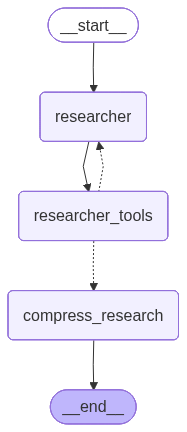

In [11]:
# Build researcher graph
researcher_builder = StateGraph(
    ResearcherState,
    output_schema=ResearcherOutputState
)

# Add nodes
researcher_builder.add_node("researcher", researcher)
researcher_builder.add_node("researcher_tools", researcher_tools)
researcher_builder.add_node("compress_research", compress_research)

# Add edges
researcher_builder.add_edge(START, "researcher")
researcher_builder.add_edge("researcher", "researcher_tools")
# researcher_tools uses Command to route to either researcher or compress_research
researcher_builder.add_edge("compress_research", END)

# Compile
researcher_graph = researcher_builder.compile()
researcher_graph

### 1.5 Running the Single Researcher

Let's test our researcher with a simple query.

In [12]:
# Test the researcher
test_query = "What are the best practices for prompt engineering with LLMs?"

initial_state = {
    "researcher_messages": [HumanMessage(content=test_query)],
    "research_topic": test_query,
    "tool_call_iterations": 0
}

result = await researcher_graph.ainvoke(initial_state)

print("="*60)
print("RESEARCHER MESSAGE HISTORY:")
print("="*60)
for message in result["researcher_messages"]:
    message.pretty_print()

print("\n" + "="*60)
print("RESEARCH FINDINGS:")
print("="*60)
print(result["compressed_research"])

RESEARCHER MESSAGE HISTORY:
================================ Human Message =================================

What are the best practices for prompt engineering with LLMs?
================================== Ai Message ==================================

[{'id': 'ws_04533662bd75c49400695df697f9ac8194b637cf883272b0e4', 'action': {'query': 'best practices for prompt engineering with LLMs 2025', 'type': 'search'}, 'status': 'completed', 'type': 'web_search_call'}, {'type': 'text', 'text': 'Prompt engineering is the practice of crafting inputs to guide large language models (LLMs) toward producing desired outputs. Effective prompt engineering enhances the accuracy, relevance, and reliability of AI-generated content. Here are some best practices:\n\n1. **Clarity and Specificity**: Clearly define the task and provide specific instructions to reduce ambiguity. For example, instead of "Write a summary," specify "Summarize the key themes of post-colonial literature in 300 words for a high school

## Part 2: Building the Supervisor Agent

Now we'll build a supervisor agent that can:
1. Break down a research question into multiple sub-topics
2. Delegate research to multiple researcher agents in parallel
3. Collect and organize all the findings

This demonstrates the power of multi-agent systems!

### 2.1 Define Supervisor State

We can define separate state for our Supervisor. This allows it to keep track different items than the Researcher, preventing it from getting distracted by noise. 

We also define a customer reducer for handling specific state keys. By default state updates overwrite existing values - we've defined a custom reducer to allow for concatenation alongside overwrite behavior

In [13]:
def override_reducer(current_value, new_value):
    """Reducer function that allows overriding values in state."""
    if isinstance(new_value, dict) and new_value.get("type") == "override":
        return new_value.get("value", new_value)
    else:
        return operator.add(current_value, new_value)
        
class SupervisorState(TypedDict):
    """State for the supervisor agent."""
    supervisor_messages: Annotated[list[MessageLikeRepresentation], override_reducer]
    research_brief: str
    notes: Annotated[list[str], override_reducer] = []
    research_iterations: int = 0
    raw_notes: Annotated[list[str], override_reducer] = []


### 2.2 Define Supervisor Tools

In multi-agent systems, the most common way to coordinate subagents today is to call them as tools. This allows subagents to isolate their context from the supervisor's orchestration, allowing specialization and focus.

This is as simple as invoking our researcher subagent within a tool, and giving that tool to our supervisor.

In [14]:
@tool(description="Delegate a research task to a specialized researcher")
async def ConductResearch(research_topic: str) -> dict:
    """Delegate a specific research topic to a researcher agent.
    
    Args:
        research_topic: Clear, specific research question for the sub-agent
    """
    # Actually invoke the researcher graph
    result = await researcher_graph.ainvoke({
        "researcher_messages": [HumanMessage(content=research_topic)],
        "research_topic": research_topic,
        "tool_call_iterations": 0
    })
    
    # Return dictionary directly with both compressed research and raw notes
    return {
        "compressed_research": result.get("compressed_research", "Error in research"),
        "raw_notes": result.get("raw_notes", [])
    }

@tool(description="Signal that all research is complete")
def ResearchComplete() -> str:
    """Call this when you have gathered all necessary information."""
    return "Research marked as complete"

### 2.3 Define Supervisor Nodes



In [15]:
lead_researcher_prompt = """You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool.

<Task>
Call the "ConductResearch" tool to delegate research. When you're satisfied with findings, call "ResearchComplete".
</Task>

<Available Tools>
1. **ConductResearch**: Delegate research tasks to specialized sub-agents
2. **ResearchComplete**: Indicate that research is complete
3. **think_tool**: For reflection and strategic planning

**CRITICAL: Use think_tool before calling ConductResearch to plan, and after to assess progress.**
</Available Tools>

<Instructions>
Think like a research manager:

1. **Read the question carefully** - What specific information is needed?
2. **Decide how to delegate** - Can multiple independent angles be explored simultaneously?
3. **After each ConductResearch call, assess** - Do I have enough? What's missing?
</Instructions>

<Hard Limits>
- **Limit tool calls** - Stop after {max_researcher_iterations} tool calls if you cannot find the right sources
- **Maximum {max_concurrent_research_units} parallel agents per iteration**
</Hard Limits>

<Scaling Rules>
**Simple queries** - Use a single sub-agent
**Comparisons** - Use a sub-agent for each element being compared
**Important**: Provide complete standalone instructions when calling ConductResearch
</Scaling Rules>
"""

In [16]:
async def supervisor(state: SupervisorState, config):
    """Supervisor agent that delegates research."""
    lead_researcher_tools = [ConductResearch, ResearchComplete, think_tool]
    
    research_model = (
        get_model()
        .bind_tools(lead_researcher_tools)
        .with_retry(stop_after_attempt=MAX_STRUCTURED_OUTPUT_RETRIES)
    )
    
    supervisor_messages = state.get("supervisor_messages", [])
    response = await research_model.ainvoke(supervisor_messages)
    
    return {
        "supervisor_messages": [response],
        "research_iterations": state.get("research_iterations", 0) + 1
    }

In [17]:
def extract_tool_content(messages):
    """Extract notes from tool call messages."""
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

async def supervisor_tools(state: SupervisorState, config) -> Command[Literal["supervisor", "__end__"]]:
    """Execute tools called by the supervisor."""
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Check exit conditions
    exceeded_iterations = research_iterations > MAX_RESEARCHER_ITERATIONS
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tc["name"] == "ResearchComplete"
        for tc in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        return Command(
            goto=END,
            update={
                "notes": extract_tool_content(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    
    # Process tool calls
    all_tool_messages = []
    update_payload = {"supervisor_messages": []}
    
    # Handle think_tool
    for tc in most_recent_message.tool_calls:
        if tc["name"] == "think_tool":
            all_tool_messages.append(ToolMessage(
                content=f"Reflection recorded: {tc['args']['reflection']}",
                name="think_tool",
                tool_call_id=tc["id"]
            ))
    
    # Handle ConductResearch - now executes the actual tool
    conduct_research_calls = [
        tc for tc in most_recent_message.tool_calls
        if tc["name"] == "ConductResearch"
    ]
    
    if conduct_research_calls:
        try:
            allowed_calls = conduct_research_calls[:MAX_CONCURRENT_RESEARCH_UNITS]
            overflow_calls = conduct_research_calls[MAX_CONCURRENT_RESEARCH_UNITS:]
            
            # Execute research tasks in parallel by invoking the tool
            research_tasks = [
                ConductResearch.ainvoke(tc["args"])
                for tc in allowed_calls
            ]
            
            # Get results directly as dictionaries
            tool_results = await asyncio.gather(*research_tasks)
            
            # Create tool messages with results
            for observation_dict, tc in zip(tool_results, allowed_calls):
                all_tool_messages.append(ToolMessage(
                    content=observation_dict.get("compressed_research", "Error in research"),
                    name=tc["name"],
                    tool_call_id=tc["id"]
                ))
            
            # Handle overflow
            for overflow_call in overflow_calls:
                all_tool_messages.append(ToolMessage(
                    content=f"Error: Exceeded max concurrent units ({MAX_CONCURRENT_RESEARCH_UNITS})",
                    name="ConductResearch",
                    tool_call_id=overflow_call["id"]
                ))
            
            # Aggregate raw notes
            raw_notes_concat = "\n".join([
                "\n".join(obs.get("raw_notes", []))
                for obs in tool_results
            ])
            
            if raw_notes_concat:
                update_payload["raw_notes"] = [raw_notes_concat]
        
        except Exception as e:
            return Command(
                goto=END,
                update={
                    "notes": extract_tool_content(supervisor_messages),
                    "research_brief": state.get("research_brief", "")
                }
            )
    
    update_payload["supervisor_messages"] = all_tool_messages
    return Command(goto="supervisor", update=update_payload)

### 2.4 Build Supervisor Graph

In [18]:
# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)

supervisor_builder.add_edge(START, "supervisor")
supervisor_builder.add_edge("supervisor", "supervisor_tools")
# supervisor_tools uses Command to route back to supervisor or END

supervisor_graph = supervisor_builder.compile()

### 2.5 Test the Supervisor

Let's test the supervisor with a research question!

In [19]:
# Test the supervisor
research_brief = "Recommend some chinese restaurants and indian restaurants in NYC"

supervisor_system_prompt = lead_researcher_prompt.format(
    date=get_today_str(),
    max_concurrent_research_units=MAX_CONCURRENT_RESEARCH_UNITS,
    max_researcher_iterations=MAX_RESEARCHER_ITERATIONS
)

initial_state = {
    "supervisor_messages": [
        SystemMessage(content=supervisor_system_prompt),
        HumanMessage(content=research_brief)
    ],
    "research_brief": research_brief,
    "research_iterations": 0,
    "notes": [],
    "raw_notes": []
}
result = await supervisor_graph.ainvoke(initial_state)

print("="*60)
print("SUPERVISOR MESSAGE HISTORY:")
print("="*60)
for message in result["supervisor_messages"]:
    message.pretty_print()

print("\n" + "="*60)
print("COLLECTED RESEARCH NOTES:")
print("="*60)
for i, note in enumerate(result["notes"], 1):
    print(f"\n--- Research Finding {i} ---")
    print(note[:500] + "..." if len(note) > 500 else note)

SUPERVISOR MESSAGE HISTORY:
================================ System Message ================================

You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool.

<Task>
Call the "ConductResearch" tool to delegate research. When you're satisfied with findings, call "ResearchComplete".
</Task>

<Available Tools>
1. **ConductResearch**: Delegate research tasks to specialized sub-agents
2. **ResearchComplete**: Indicate that research is complete
3. **think_tool**: For reflection and strategic planning

**CRITICAL: Use think_tool before calling ConductResearch to plan, and after to assess progress.**
</Available Tools>

<Instructions>
Think like a research manager:

1. **Read the question carefully** - What specific information is needed?
2. **Decide how to delegate** - Can multiple independent angles be explored simultaneously?
3. **After each ConductResearch call, assess** - Do I have enough? What's missing?
</Instructions>

<Hard Limits>

## Part 3: Adding Human-in-the-Loop

This is the full production-ready research agent!

### 3.1 Define Main Agent State

We can now put together the State for our overall graph to track. We can share State with the supervisor by including the same keys in our overall State. This allows the supervisor to inherit information gleaned from our human feedback.

In [20]:
class AgentState(TypedDict):
    """State for the complete research agent."""
    messages: list              # User conversation
    research_brief: str         # Processed research goal
    supervisor_messages: list   # Supervisor conversation
    research_iterations: int    # Tracking iterations
    notes: list                # Collected findings
    raw_notes: list            # Raw notes
    final_report: str          # Generated report

class AgentInputState(TypedDict):
    """Input to the agent - just user messages."""
    messages: list

### 3.2 Add Human in the Loop

This node uses `interrupt()` to inject human feedback on the research topic.

In [21]:
class ClarifyWithUser(TypedDict):
    """Structured output for clarification."""
    need_clarification: bool
    question: str
    verification: str

clarify_with_user_instructions = """These are the messages exchanged so far:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question.

If you need to ask a question:
- Be concise while gathering necessary information
- Don't ask for information already provided

Respond in JSON with these keys:
{{"need_clarification": boolean, "question": "...", "verification": "..."}}

If clarification needed:
{{"need_clarification": true, "question": "<your question>", "verification": ""}}

If no clarification needed:
{{"need_clarification": false, "question": "", "verification": "<acknowledgement message>"}}
"""

async def clarify_with_user(state: AgentState, config):
    """Ask clarifying questions if needed using human-in-the-loop."""
    messages = state["messages"]
    
    # Configure model for structured clarification
    clarification_model = (
        get_model()
        .with_structured_output(ClarifyWithUser)
        .with_retry(stop_after_attempt=MAX_STRUCTURED_OUTPUT_RETRIES)
    )
    
    # Analyze whether clarification is needed
    prompt_content = clarify_with_user_instructions.format(
        messages=get_buffer_string(messages),
        date=get_today_str()
    )
    response = await clarification_model.ainvoke([HumanMessage(content=prompt_content)])
    
    # If clarification needed, use interrupt to pause for user input
    if response["need_clarification"]:
        user_response = interrupt(response["question"])
        return {"messages": [HumanMessage(content=user_response)]}
    else:
        # No clarification needed
        return {"messages": [AIMessage(content=response["verification"])]}

Next, we'll create another node to take the research prompt with human feedback included, and use it to generate a high level plan. Keeping this plan available to our agent through the State key research_brief will allow our agent to stay on track even with complicated tasks.

In [22]:
class ResearchQuestion(TypedDict):
    """Structured research question."""
    research_brief: str

create_research_brief_prompt = """Translate these messages into a detailed research question:

<Messages>
{messages}
</Messages>

Today's date is {date}.

Guidelines:
1. Maximize specificity and detail - include all user preferences
2. Fill in unstated but necessary dimensions as open-ended
3. Avoid unwarranted assumptions
4. Use first person (from user's perspective)
5. For product/travel research, prefer official sources
"""

async def write_research_brief(state: AgentState, config) -> Command[Literal["research_supervisor"]]:
    """Transform user messages into a structured research brief."""
    # Configure model for structured output
    research_model = (
        get_model()
        .with_structured_output(ResearchQuestion)
        .with_retry(stop_after_attempt=MAX_STRUCTURED_OUTPUT_RETRIES)
    )
    
    # Generate research brief
    prompt_content = create_research_brief_prompt.format(
        messages=get_buffer_string(state.get("messages", [])),
        date=get_today_str()
    )
    response = await research_model.ainvoke([HumanMessage(content=prompt_content)])
    
    # Initialize supervisor
    supervisor_system_prompt = lead_researcher_prompt.format(
        date=get_today_str(),
        max_concurrent_research_units=MAX_CONCURRENT_RESEARCH_UNITS,
        max_researcher_iterations=MAX_RESEARCHER_ITERATIONS
    )
    
    return {
        "research_brief": response["research_brief"],
        "supervisor_messages": {
            "type": "override",
            "value": [
                SystemMessage(content=supervisor_system_prompt),
                HumanMessage(content=response["research_brief"])
            ]
        }
    }
    


### 3.3 Format Outputs

In [23]:
final_report_generation_prompt = """Based on all research conducted, create a comprehensive answer to:
<Research Brief>
{research_brief}
</Research Brief>

Today's date is {date}.

Here are the findings:
<Findings>
{findings}
</Findings>

Create a detailed answer that:
1. Is well-organized with proper headings (# for title, ## for sections)
2. Includes specific facts from the research
3. References sources using [Title](URL) format
4. Provides comprehensive analysis
5. Includes a "Sources" section at the end

Structure your report appropriately:
- For comparisons: intro → overview A → overview B → comparison → conclusion
- For lists: just the list with details
- For summaries: overview → key concepts → conclusion

Use ## for section titles. Be thorough - users expect deep research.
"""

async def final_report_generation(state: AgentState, config):
    """Generate the final comprehensive research report."""
    notes = state.get("notes", [])
    findings = "\n".join(notes)
    
    # Create report prompt
    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        messages=get_buffer_string(state.get("messages", [])),
        findings=findings,
        date=get_today_str()
    )
    
    # Generate report
    final_report = await get_model().ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content,
        "messages": [final_report],
        "notes": {"type": "override", "value": []}
    }

### 3.4 Compile with Persistence

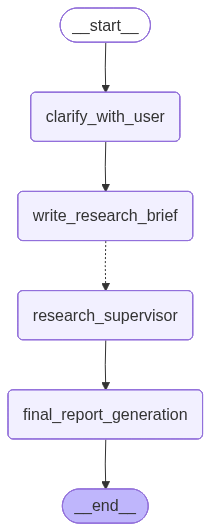

In [24]:
# Create checkpointer for interrupt/resume support
checkpointer = MemorySaver()

# Build complete research workflow
deep_researcher_builder = StateGraph(
    AgentState,
    input_schema=AgentInputState
)

# Add nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("research_supervisor", supervisor_graph)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("clarify_with_user", "write_research_brief")
deep_researcher_builder.add_edge("write_research_brief", "research_supervisor")
deep_researcher_builder.add_edge("research_supervisor", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile with checkpointer for interrupt/resume support
deep_research_graph = deep_researcher_builder.compile(checkpointer=checkpointer)
deep_research_graph

### 3.5 Test HITL and Persistence

Let's test the full research workflow!

In [25]:
# Test complete workflow
import uuid

test_query = "Recommend the best Chinese restaurants in Manhattan"

initial_state = {
    "messages": [HumanMessage(content=test_query)]
}

# Create config with thread_id for checkpointing
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# First invocation - will pause at interrupt if clarification needed
print("Starting research workflow...")
result = await deep_research_graph.ainvoke(initial_state, config=config)

# Check if we hit an interrupt
if "__interrupt__" in result:
    print("\n" + "="*60)
    print("INTERRUPT: Clarification question detected")
    print("="*60)
    
    # Get the state to see the interrupt details
    state_snapshot = deep_research_graph.get_state(config)
    
    # Show the interrupt value (the clarification question)
    if hasattr(state_snapshot, 'tasks') and state_snapshot.tasks:
        for task in state_snapshot.tasks:
            if hasattr(task, 'interrupts') and task.interrupts:
                for interrupt_info in task.interrupts:
                    print(f"Question: {interrupt_info.value}")

Starting research workflow...

INTERRUPT: Clarification question detected
Question: Are you looking for upscale dining, casual spots, or takeout options?

Resuming with: 'Use your best judgement'

MAIN AGENT MESSAGE HISTORY:
================================== Ai Message ==================================

[{'type': 'text', 'text': '# Comprehensive Review: Methods and Best Practices for Responding to Open-Ended or Ambiguously Stated User Prompts (January 2026)\n\n## Introduction\n\nAddressing open-ended or ambiguous user prompts—especially when provided with minimal context—is a recurring challenge across domains such as artificial intelligence (AI), customer service, technical support, and academic research. As of January 2026, rapid advancements in prompt engineering, dialogue systems, and transparency frameworks have produced a robust set of methods, best practices, and documentation standards to systematically manage this challenge. This report synthesizes state-of-the-art research,

In [ ]:
print("\nResuming with: 'Use your best judgement'")
print("="*60 + "\n")
    
# Resume from interrupt with our response
result = await deep_research_graph.ainvoke(Command(resume="Use your best judgement"), config=config)

print("\n" + "="*60)
print("FINAL RESEARCH REPORT:")
print("="*60)
print(result["final_report"])